# Visualization of different values of discriminative need

(For one meaning distribution)

## Configs

In [148]:
import os
import torch
import pandas as pd
import plotnine as pn

In [149]:
# Constants 

# example fn
"multirun/states=10/words=10/prior=-8/dist=squared_dist/meaning_certainty=-2/discr_need=-1/seed=42/dynamics=two_population_rd/num_trials=10/population_size=None/simulation_points.csv"

# standard configs
num_states = 10
num_signals = 10
prior = -8
distance = "squared_dist"
meaning_certainty = 0
seed = 42

discr_needs = torch.arange(-3, 4, 0.5).tolist() # swept values
# discr_needs = torch.arange(-3, -1, 0.5).tolist() # for 1000

# Replicator Dynamics specific configs
dynamics = "two_population_rd"
num_trials = 8
population_size = None

# # Nowak Krakauer specific configs
# dynamics = "nowak_krakauer"
# num_trials = 8
# population_size = 100

# # Moran process specific configs
# dynamics = "moran_process"
# num_trials = 8
# population_size = 100

## Load Data

In [150]:
# Filepaths

# user's path to root of repo
root_path = "/Users/nathanielimel/uci/projects/ibsg"

#############################################################################
# Analysis files
#############################################################################

curve_fn = f"multirun/states={num_states}/signals={num_signals}/prior={prior}/dist={distance}/meaning_certainty={meaning_certainty}/curve_points.csv"

#############################################################################
# Simulation points
#############################################################################

sim_fns = {
    f"{discr_need}":
    f"multirun/states={num_states}/signals={num_signals}/prior={prior}/dist={distance}/meaning_certainty={meaning_certainty}/discr_need={discr_need}/seed={seed}/dynamics={dynamics}/num_trials={num_trials}/population_size={population_size}/simulation_points.csv"
    for discr_need in discr_needs
    } 

In [151]:
# load dataframes
read = lambda fn: pd.read_csv(os.path.join(root_path, fn))

curve_data = read(curve_fn)
sim_dfs = {k: read(sim_fns[k]) for k in sim_fns}
# curve_data = pd.read_csv(curve_fn)
# sim_dfs = {k: pd.read_csv(sim_fns[k]) for k in sim_fns}

## Configure aesthetics

In [152]:
# label each df to be concatenated with a columns
for key in sim_dfs:
    df = sim_dfs[key]
    df["discr_need"] = key

sim_data = pd.concat(sim_dfs.values())

In [153]:
data = sim_data

In [154]:
data["discr_need"] = data["discr_need"].astype(float)

# data = data.assign(
#     alpha=pd.Categorical(
#         data["discr_need"],
#         categories=[str(discr_need) for discr_need in discr_needs]
#     )
# )
data # N.B.: nans are expected for 'round' column

,complexity,accuracy,discr_need
0,1.330376e-04,1.263619e-04,-3.0
1,5.402565e-04,5.130768e-04,-3.0
2,7.190704e-04,6.842613e-04,-3.0
3,8.077622e-04,7.677078e-04,-3.0
4,2.899170e-04,2.765656e-04,-3.0
...,...,...,...
3,8.498433e-01,7.627189e-01,3.5
4,0.000000e+00,0.000000e+00,3.5
5,2.384186e-07,-2.384186e-07,3.5
6,0.000000e+00,0.000000e+00,3.5


In [155]:
# label point type
data["language"] = "emergent"

## Plot

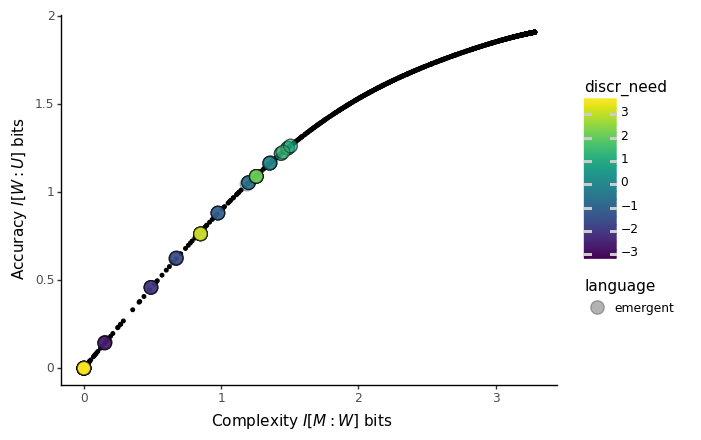

In [156]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    # + pn.geom_line(size=1) # IB curve
    + pn.geom_point(size=1)
    + pn.geom_jitter( # emergent langs
        data=data,
        mapping=pn.aes(
            fill="discr_need",
            shape="language",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

In [158]:
# Uncomment to save!
# plot.save("10x10_game_two_pop_rd.png", width=10, height=10, dpi=300)

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: 10x10_game_two_pop_rd.png
